# Parking Ocuppancy Predictor

El objetivo es predecir el porcentaje de espacios libres para una cuadra determinada, dia y hora. En principio, se utiliza solo los datos historicos, posteriormente la idea es añadirle diversas fuentes de informacion. De modo, que estas mejoren la predicción.

In [1]:
%matplotlib inline
import matplotlib as matplotlib;
import matplotlib.pyplot as plt;
import pandas as pd;
import numpy as np;
import seaborn as sns;

Carga del dataset:

In [2]:
data_path = "https://raw.githubusercontent.com/chirichignoa/Parking-Ocuppancy-Predictor/master/dataset/BD_parking_with_address.csv"
dataset = pd.read_csv(data_path);

## Preprocesamiento

Se eliminan los registros con el **id_cuadra** igual a 50 que corresponde a la oficina SUMO y solo se utiliza para cuestiones administrativas. En caso de querer **filtrar datos para una cuadra especifica** descomentar las siguientes lineas. La segunda es la que realiza el filtrado y la restante, visualiza los datos para comprobar.

In [3]:
dataset = dataset[dataset['id_cuadra']!=50]
# dataset = dataset[(dataset.id_cuadra == 11) | (dataset.id_cuadra == 59) | (dataset.id_cuadra == 39)]
# dataset.head(10)

Se ordena el dataset de acuerdo a la fecha y a la hora de las operaciones

In [4]:
dataset = dataset.sort_values(['fecha', 'hora'])

Se genera una columna nueva, con el merge de la **fecha** y de la **hora** y se la redondea hacia el valor menor cercano en un rango de 15 minutos. Por ejemplo, la hora 11:26 se traduce a 11:30

In [5]:
dataset['time'] = pd.to_datetime(dataset.fecha + " " + dataset.hora,format="%Y-%m-%d %H:%M:%S.%f").dt.round('15min')

Se desean eliminar los datos del dia domingo, ya que el sistema no se encuentra habilitado en dicho dia. Para esto, se debe convertir la fecha al formato **day of week**. Se genera una nueva columna que almacenara dicho dato. 

In [6]:
dataset['fecha'] = pd.to_datetime(dataset.fecha ,format="%Y-%m-%d")
dataset['hora'] = pd.to_datetime(dataset.hora,format="%H:%M:%S.%f")
dataset['dow'] = dataset['fecha'].apply(lambda fecha: fecha.weekday())
dataset = dataset[dataset['dow']!=6]

Luego se eliminan aquellas operaciones que no correspondan al horario funcional del sistema SUMO, el cual es desde las 10:00 AM hasta 20:00 PM. **Nota:** en caso de querer filtrar los datos por una cierta fecha se debe descomentar la linea que contiene la variable fecha, y utilizar la variable **_mask_** que contenga el filtro por la fecha.

In [7]:
time_start = pd.to_datetime('10:00:00.000000',format="%H:%M:%S.%f");
time_end = pd.to_datetime('20:00:00.000000',format="%H:%M:%S.%f");
# fecha = pd.to_datetime('2018-06-01' ,format="%Y-%m-%d")

mask = (time_start <= dataset['hora']) & (dataset['hora'] <= time_end);
# mask = (dataset['fecha'] == fecha) & (time_start <= dataset['hora']) & (dataset['hora'] <= time_end);
dataset = dataset[mask];

Luego de haber filtrado los registros de acuerdo al horario funcional del sistema, se eliminan las columnas de fecha y hora, las cuales no son necesarias a partir de aqui.

In [8]:
dataset = dataset.drop(['hora', 'fecha'], axis=1)

A continuación se puede visualizar los datos, para ver el resultado de toda la transformación anterior:

In [9]:
dataset.head(10)

,id_cuadra,operacion,tarjeta,direccion,time,dow
1,40,Entrada,10059452,Mitre 348,2018-01-01 11:30:00,0
351452,40,Salida,10059452,Mitre 348,2018-01-01 11:30:00,0
2,61,Entrada,10032179,Chacabuco 357,2018-01-01 13:15:00,0
351453,61,Salida,10032179,Chacabuco 357,2018-01-01 13:30:00,0
3,34,Entrada,10026609,Sarmiento 849,2018-01-01 17:00:00,0
4,66,Entrada,10073847,Rodriguez 846,2018-01-01 17:30:00,0
5,16,Entrada,10012270,San Martin 852,2018-01-01 18:15:00,0
493,52,Entrada,10007005,Chacabuco 646,2018-01-01 18:30:00,0
517,52,Entrada,10057514,Chacabuco 646,2018-01-01 18:30:00,0
564,52,Entrada,10096601,Chacabuco 646,2018-01-01 18:30:00,0


Una vez obtenido los datos funcionales del sistema, se procede a separar los datos de acuerdo al tipo de operación. Se crean dos nuevos dataframes que contienen los datos asociados a los ingresos y egresos del sistema. A modo de comparación, finalmente se muestra el tamaño de cada uno, es decir la cantidad de operaciones de cada tipo. 

In [10]:
dfi = dataset[dataset['operacion']=='Entrada']
dfo = dataset[dataset['operacion']=='Salida']
print("Ingresos: {} - Egresos: {}".format(dfi.shape[0], dfo.shape[0]))

Ingresos: 316370 - Egresos: 327930


Una vez separado los datos, es necesario llevar un conteo de todos los registros correspondientes a una cuadra y al mismo rango horario, discriminando si se corresponde a un ingreso o a un egreso. De este modo, se generan las columnas **count_in** y **count_out** que contienen la cantidad total de entradas y de salidas. 

Se eliminan las columnas **operacion**, **tarjeta** y **direccion** quedando solamente la informacion relacionada a la cuadra, el rango de tiempo y la cantidad de entradas o de salidas de cada dataframe. 

In [11]:
def get_count(df, column_name):
    dataframe = df;
    dataframe = dataframe.set_index('time');
    dataframe = dataframe.groupby(by=['id_cuadra', pd.Grouper(freq='15Min')]).count();
    dataframe = dataframe[dataframe['operacion'] != 0];
    dataframe[column_name] = dataframe['operacion'];
    dataframe = dataframe.drop(['operacion', 'tarjeta', 'dow', 'direccion'], axis=1);
    return dataframe;

In [12]:
dfi = get_count(dfi, "count_in")
dfo = get_count(dfo, "count_out")

De este modo, se reducen los datasets de acuerdo al rango horario y se cuenta la cantidad de registros que pertenecen a ese rango. A continuación se puede visualizar el tamaño de cada uno de los datasets:

In [13]:
print("Ingresos: {} - Egresos: {}".format(dfi.shape[0], dfo.shape[0]))

Ingresos: 184471 - Egresos: 192777


Utilizando los datos obtenidos, se genera un dataframe definitivo realizando un merge a izquierda, ya que el dataset asociado a los egresos es el que mas filas contiene. Si se mergeara a partir de los egresos se generaria informacion que no se condice con la realidad, de modo que existen egresos sin haberse hecho ingresos. Como resultado de esta operación de mergeo, pueden existir valores faltantes en el caso de que no existan filas que tengan el mismo rango horario. En este caso, se procede a completar dichos valores faltantes (expresados como _NaN_) con el valor de 0.

In [14]:
df_count = pd.merge(dfi, dfo, left_index=True, right_index=True, how='left')
df_count = df_count.fillna(0,axis=1)
df_count['count_out'] = df_count.count_out.astype(int)
df_count['count_in'] = df_count.count_in.astype(int)

De este modo, se puede ver el tamaño del dataset resultante y una visualizacion de los datos. Cabe destacar, que estos datos se agruparon conun doble index compuesto de **'id_cuadra'** y **'time'**

In [15]:
print("Tamaño del dataset definitivo: {}".format(df_count.shape[0]))
df_count.head()

Tamaño del dataset definitivo: 184471


count_in  count_out
id_cuadra time                                    
2         2018-01-02 10:00:00         2          0
          2018-01-02 10:15:00         2          0
          2018-01-02 10:45:00         1          3
          2018-01-02 11:00:00         1          1
          2018-01-02 11:15:00         4          0

## Generacion de lugares disponibles por cuadras

Estos datos, ya se encuentran generados y almacenados en un documento csv, por lo que se procede a cargar dichos datos en un dataframe:

In [16]:
data_path = "https://raw.githubusercontent.com/chirichignoa/Parking-Ocuppancy-Predictor/master/dataset/cant_espacios.csv"
cant_lugares = pd.read_csv(data_path);
cant_lugares.head()

,id_cuadra,direccion,cant_espacios
0,2,General Pinto 545,29
1,3,San Marti­n 452,14
2,4,Rodriguez 552,15
3,5,9 de Julio 441,16
4,6,General Pinto 759,9


Luego se seleccionan los datos relevantes de dicha información cargada, los cuales son el **'id_cuadra'** y **'cant_espacios'**

In [17]:
cant_lugares = cant_lugares[['id_cuadra', 'cant_espacios']]
cant_lugares = cant_lugares.set_index('id_cuadra')

La siguiente función permite obtener la cantidad total de lugares disponibles para cada una de las cuadras:

In [18]:
def get_total_spaces(id_cuadra):
    return cant_lugares.at[id_cuadra,'cant_espacios']

A partir de los datos obtenidos, mediante el proceso de preprocesamiento y de los datos de la cantidad total de lugares disponibles de estacionamiento, se procede a calcular la disponibilidad para cada uno de los rangos de tiempo. Mediante la siguiente funcion se alcanza dicho objetivo, realizando una iteracion por cada una de las filas de dataframe, y utilizando la función definida que retorna la cantidad de lugares disponibles, se realiza  la siguiente suma:


\begin{align}
{Espacios\,Disponibles_{P,T_{i-1}} - Ingresos_{P,T_{i}} + Egresos_{P,T_{i}}}
\end{align}

Donde P es el identificador de cuadra, y T es la ventana de tiempo

In [19]:
def get_occupancy(df):
    df_count = df.copy();
    prev_date = "1900-00-00";
    prev_cuadra = 0;
    total_spaces = 0;
    ret = [];
    partial_sum = 0;
    available = 0;
    for row in df_count.iterrows():
        # row[0][0] id_cuadra
        # row[0][1] time
        # row[1][0] count_in
        # row[1][1] count_out
        id_cuadra = row[0][0];
        date = row[0][1];
        splitted = str(row[0][1]).split();
        if(prev_cuadra != id_cuadra):
            total_spaces = get_total_spaces(id_cuadra);
            prev_cuadra = id_cuadra;
        if(prev_date != splitted[0]):
            available = total_spaces;
            prev_date = splitted[0];
            partial_sum = available;

        partial_sum = partial_sum - row[1][0] + row[1][1];
        ret.append(partial_sum);
    df_count['available'] = ret;
    return df_count;

In [20]:
df_count = get_occupancy(df_count);

Luego se genera una columna con la cantidad de espacios totales para cada cuadra:

In [21]:
df_count['total'] = df_count.apply(lambda row: get_total_spaces(row.name[0]), axis=1)
df_count.head()

count_in  count_out  available  total
id_cuadra time                                                      
2         2018-01-02 10:00:00         2          0         27     29
          2018-01-02 10:15:00         2          0         25     29
          2018-01-02 10:45:00         1          3         27     29
          2018-01-02 11:00:00         1          1         27     29
          2018-01-02 11:15:00         4          0         23     29

Ahora en base a los datos generados, se obtiene el porcentaje de disponibilidad o **AVR**. El cual se define formalmente como:

\begin{align} AVR_{P,T_{i}}	=\cfrac{Espacios\,Disponibles_{P,T_{i-1}}-Ingresos_{P,T_{i}}+Egresos_{P,T_{i}}}{Espacios\,Totales_{P}}\end{align}

In [22]:
def get_avr(available, total):
    avr = (available / total);
    if(avr > 1):
        return 1;
    if(avr < 0):
        return 0;
    return avr;

Cabe destacar que, al haber generado manuelmente la cantidad de espacios disponibles por cuadra, pueda que exista un error de estimación. Esto significa que puede haber cuadras donde la cantidad de espacios disponibles supere el total, o sea menor que 0. De este modo, para evitar cifras no deseadas, se decidió por acotar los valores que se exceden.

In [23]:
df_count['avr'] = df_count.apply(lambda row: get_avr(row.available, row.total), axis=1)
df_count.head()

count_in  count_out  available  total       avr
id_cuadra time                                                                
2         2018-01-02 10:00:00         2          0         27     29  0.931034
          2018-01-02 10:15:00         2          0         25     29  0.862069
          2018-01-02 10:45:00         1          3         27     29  0.931034
          2018-01-02 11:00:00         1          1         27     29  0.931034
          2018-01-02 11:15:00         4          0         23     29  0.793103

Una vez generado el AVR, se procede a eliminar las columnas con los lugares disponibles y totales, ya que no son necesarias para el calculo posterior. Por lo que se genera el dataframe que servira para la predicción. Ademas, se transforma la columna time en el dia de la semana asociada a esa fecha.

In [24]:
df_feature = df_count.copy()
df_feature = df_feature.reset_index()
df_feature = df_feature[['id_cuadra', 'count_in','count_out', 'time', 'avr']]
df_feature['dow'] = df_feature['time'].dt.dayofweek

Para lograr una mejor eficiencia en cuanto a predicción, se categorizaran las ventanas de tiempo sobre la columna **time** en base al arreglo generado a continuación, y seleccionando solo el horario. Por ejemplo para la hora 10:00 correspondera el indice o categoria 0

In [25]:
times = ["10:00:00", "10:15:00", "10:30:00", "10:45:00", "11:00:00", "11:15:00", "11:30:00",
"11:45:00", "12:00:00", "12:15:00", "12:30:00", "12:45:00", "13:00:00", "13:15:00", "13:30:00", "13:45:00", "14:00:00",
"14:15:00", "14:30:00", "14:45:00", "15:00:00", "15:15:00", "15:30:00", "15:45:00", "16:00:00", "16:15:00", "16:30:00",
"16:45:00", "17:00:00", "17:15:00", "17:30:00", "17:45:00", "18:00:00", "18:15:00", "18:30:00", "18:45:00", "19:00:00",
"19:15:00", "19:30:00", "19:45:00", "20:00:00"]
def get_index(time):
    return times.index(time);

In [26]:
df_feature['time'] = df_feature['time'].apply(lambda time: get_index(str(time).split()[1]))

## Predicción

Debido a que se pretende predecir un valor numerico como lo es el porcentaje de disponibilidad. Se utilizaran las siguientes tecnicas de _Machine Learning_:
 1. **Linear Regression** (LNR)
 2. **Regression Tree** (RT)
 3. **Gradient Boosting Regression** (GBR)

Se medira la performance de estas tecnicas utilizando distintas metricas, realizando la comparación frente a dos Dummy Regressors.

Primero, separo los conjuntos de caracteristicas del conjunto de datos a predecir, donde X es el conjunto de caracteristicas; y el conjunto de porcentaje de estacionamiento disponible. De modo que dado X se buscara predecir y.

In [27]:
labels = df_feature['avr']
df_feature = df_feature.drop('avr', axis=1)

Para la validación de las predicciones se utilizara la tecnica _k-fold cross validation_ con un total de 5 folds. Para esto es necesario separar las caracteristicas en dos conjuntos: conjunto de entrenamiento y conjunto de test. Esto se hace tanto para las caracteristicas como para las datos a predecir.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_feature, labels, test_size=0.25,random_state =1 )

### Dummy Regressor

In [29]:
from sklearn import dummy
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = dummy.DummyRegressor(strategy='mean') 
model.fit(X_train, y_train);
y_predicted_dr = model.predict(X_test);
# The mean squared error
dummy_mse = mean_squared_error(y_test, y_predicted_dr);
print("Mean squared error: %.3f"
      % dummy_mse);
# The mean absolute error
dummy_mae = mean_absolute_error(y_test, y_predicted_dr);
print("Mean absolute error: %.3f"
      % dummy_mae);
# Explained variance score: 1 is perfect prediction
dummy_r2 = r2_score(y_test, y_predicted_dr);
print('R2 score: %.8f' % dummy_r2);

Mean squared error: 0.064
Mean absolute error: 0.201
R2 score: -0.00000001


### Improved Dummy Regressor

In [30]:
def predict_dummy_avr(id_cuadra, time, dow, k):
    ret = df_train[(df_train.id_cuadra == id_cuadra) & (df_train.time == time) & (df_train.dow == dow)]
    if (ret.shape[0] >= k):
        ret = ret.sample(k);
    return np.nan_to_num(np.mean(ret.avr));

df_train = X_train.copy();
df_train['avr'] = y_train;
y_predicted_drm = [];
k = 2;
X_test.apply(lambda row: y_predicted_drm.append(predict_dummy_avr(row.id_cuadra, row.time, row.dow, k)), axis=1);
# The mean squared error
a_dummy_mse = mean_squared_error(y_test, y_predicted_drm);
print("Mean squared error: %.3f"
      % a_dummy_mse);
# The mean absolute error
a_dummy_mae = mean_absolute_error(y_test, y_predicted_drm);
print("Mean absolute error: %.3f"
      % a_dummy_mae);
# Explained variance score: 1 is perfect prediction
a_dummy_r2 = r2_score(y_test, y_predicted_drm);
print('R2 score: %.8f' % a_dummy_r2);

Mean squared error: 0.048
Mean absolute error: 0.157
R2 score: 0.24872911


### Linear Regression

In [31]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = linear_model.LinearRegression() 
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]} 
grid = GridSearchCV(model,parameters, cv=7, scoring='r2')
grid.fit(X_train, y_train);
print("Best parameters set found on development set:")
print()
print(grid.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
y_predicted_lr = grid.predict(X_test)
# The mean squared error
linear_mse = mean_squared_error(y_test, y_predicted_lr)
print("Mean squared error: %.3f"
      % linear_mse)
# The mean absolute error
linear_mae = mean_absolute_error(y_test, y_predicted_lr)
print("Mean absolute error: %.3f"
      % linear_mae)
# Explained variance score: 1 is perfect prediction
linear_r2 = r2_score(y_test, y_predicted_lr)
print('R2 score: %.3f' % linear_r2)

Best parameters set found on development set:

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

Grid scores on development set:

0.359 (+/-0.005) for {'copy_X': True, 'fit_intercept': True, 'normalize': True}
0.359 (+/-0.005) for {'copy_X': True, 'fit_intercept': True, 'normalize': False}
-0.524 (+/-0.052) for {'copy_X': True, 'fit_intercept': False, 'normalize': True}
-0.524 (+/-0.052) for {'copy_X': True, 'fit_intercept': False, 'normalize': False}
0.359 (+/-0.005) for {'copy_X': False, 'fit_intercept': True, 'normalize': True}
0.359 (+/-0.005) for {'copy_X': False, 'fit_intercept': True, 'normalize': False}
-0.524 (+/-0.052) for {'copy_X': False, 'fit_intercept': False, 'normalize': True}
-0.524 (+/-0.052) for {'copy_X': False, 'fit_intercept': False, 'normalize': False}

Mean squared error: 0.041
Mean absolute error: 0.155
R2 score: 0.365


### Regression Tree

In [32]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = DecisionTreeRegressor(max_depth=3)
parameters = {'max_depth':[10]} 
grid = GridSearchCV(model,parameters, cv=7, scoring='r2')
grid.fit(X_train, y_train); 
print("Best parameters set found on development set:")
print()
print(grid.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
y_predicted_rt = grid.predict(X_test)
# The mean squared error
regtree_mse = mean_squared_error(y_test, y_predicted_rt)
print("Mean squared error: %.3f"
      % regtree_mse)
# The mean absolute error
regtree_mae = mean_absolute_error(y_test, y_predicted_rt)
print("Mean absolute error: %.3f"
      % regtree_mae)
# Explained variance score: 1 is perfect prediction
regtree_r2 = r2_score(y_test, y_predicted_rt)
print('R2 score: %.3f' % regtree_r2)

Best parameters set found on development set:

{'max_depth': 10}

Grid scores on development set:

0.534 (+/-0.013) for {'max_depth': 10}

Mean squared error: 0.030
Mean absolute error: 0.129
R2 score: 0.536


### Gradient Boost Regression

In [33]:
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = ensemble.GradientBoostingRegressor()
# parameters = {'n_estimators': [500], 'max_depth': [3,5,7], 'min_samples_split': [2,4,6,8],
#               'min_samples_leaf': [4], 'max_features': [0.2], 'random_state': [0,1] }
parameters = {'n_estimators': [500], 'max_depth': [5], 'min_samples_split': [4],
              'min_samples_leaf': [4], 'max_features': [0.2], 'random_state': [1] }
grid = GridSearchCV(model,parameters, cv=7, scoring='r2')
grid.fit(X_train, y_train); 
print("Best parameters set found on development set:")
print()
print(grid.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
y_predicted_gbr = grid.predict(X_test)
# The mean squared error
gradientboost_mse = mean_squared_error(y_test, y_predicted_gbr)
print("Mean squared error: %.3f"
      % gradientboost_mse)
# The mean absolute error
gradientboost_mae = mean_absolute_error(y_test, y_predicted_gbr)
print("Mean absolute error: %.3f"
      % gradientboost_mae)
# Explained variance score: 1 is perfect prediction
gradientboost_r2 = r2_score(y_test, y_predicted_gbr)
print('R2 score: %.3f' % gradientboost_r2 )

/home/chirichignoa/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Best parameters set found on development set:

{'max_depth': 5, 'max_features': 0.2, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 500, 'random_state': 1}

Grid scores on development set:

0.583 (+/-0.009) for {'max_depth': 5, 'max_features': 0.2, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 500, 'random_state': 1}

Mean squared error: 0.027
Mean absolute error: 0.122
R2 score: 0.586


## Resultados de las métricas

Ahora se puede ver los resultados de las metricas:

In [34]:
data = [['Dummy Regressor',dummy_mae, dummy_mse, dummy_r2],
        ['Improved Dummy Regressor',a_dummy_mae, a_dummy_mse, a_dummy_r2],
        ['Linear Regression',linear_mae, linear_mse, linear_r2],
        ['Regression Tree',regtree_mae, regtree_mse, regtree_r2],
        ['Gradient Boost Regression', gradientboost_mae, gradientboost_mse, gradientboost_r2]]
df_measure = pd.DataFrame(data,columns=['Regressor','MAE', 'MSE', 'R2'])
df_measure.head()

,Regressor,MAE,MSE,R2
0,Dummy Regressor,0.201167,0.064235,-6.511157e-09
1,Improved Dummy Regressor,0.156761,0.048258,2.487291e-01
2,Linear Regression,0.154584,0.040776,3.652132e-01
3,Regression Tree,0.128671,0.029791,5.362200e-01
4,Gradient Boost Regression,0.122062,0.026611,5.857275e-01


<Figure size 432x288 with 0 Axes>

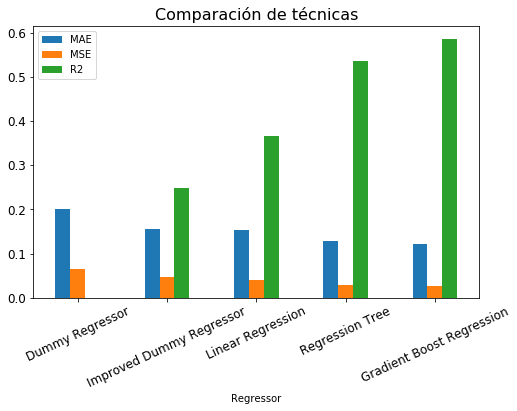

In [35]:
fig = plt.figure() # Create matplotlib figure
ax =df_measure[['Regressor', 'MAE', 'MSE', 'R2']].plot(x="Regressor",
                                                   kind="bar",
                                                   fontsize="12",
                                                   title="Comparación de técnicas", 
                                                   figsize=(8,5), 
                                                   rot=25)
ax.title.set_size(16)
plt.show()

Text(0.5,1,'e) GBR')

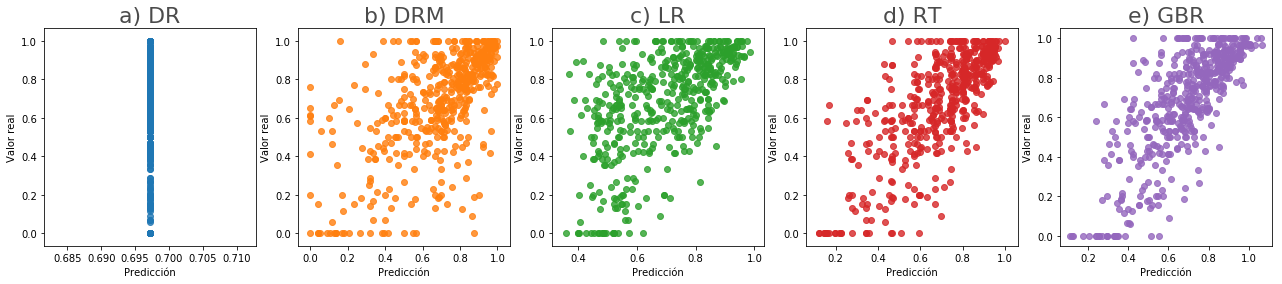

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=5)
fig.set_size_inches(22, 4)
n = 500
sns.regplot(x=y_predicted_dr[:n], y=y_test[:n], fit_reg=False, ax=ax[0])
ax[0].set_xlabel('Predicción')
ax[0].set_ylabel('Valor real')
ax[0].set_title('a) DR', fontsize=22, alpha=0.7, ha='center')
# ax[0].grid(True)
sns.regplot(x=pd.Series(y_predicted_drm[:n]), y=y_test[:n], fit_reg=False, ax=ax[1])
ax[1].set_xlabel('Predicción')
ax[1].set_ylabel('Valor real')
ax[1].set_title('b) DRM', fontsize=22, alpha=0.7, ha='center')
# ax[1].grid(True)

sns.regplot(x=y_predicted_lr[:n], y=y_test[:n], fit_reg=False, ax=ax[2])
ax[2].set_xlabel('Predicción')
ax[2].set_ylabel('Valor real')
ax[2].set_title('c) LR', fontsize=22, alpha=0.7, ha='center')
# ax[2].grid(True)

sns.regplot(x=y_predicted_rt[:n], y=y_test[:n], fit_reg=False, ax=ax[3])
ax[3].set_xlabel('Predicción')
ax[3].set_ylabel('Valor real')
ax[3].set_title('d) RT', fontsize=22, alpha=0.7, ha='center')
# ax[3].grid(True)

sns.regplot(x=y_predicted_gbr[:n], y=y_test[:n], fit_reg=False, ax=ax[4])
ax[4].set_xlabel('Predicción')
ax[4].set_ylabel('Valor real')
ax[4].set_title('e) GBR', fontsize=22, alpha=0.7, ha='center')